In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
import statsmodels.api as sm
from collections import OrderedDict 
from scipy import stats
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
colors={'lightgrey':'#bcc4cd',
        'darkgrey':'#566573',
       'myorange':'#e95c25',
       'myblue':'#4392f1',
       'mygreen':'#00a878'}

def f_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<10:
        return(np.nan)
    try: 
        f = v['female']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def m_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<10:
        return(np.nan)
    try: 
        f = v['male']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def f_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['female']
        return(f)
    except:
        return(0)

def m_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['male']
        return(f)
    except:
        return(0)

def n_papers(x):
    v = x.drop_duplicates(subset='paper_id')
    return(len(v))



def predicted_frac(df,freq,split_date,gt_max_date, covid='all'):
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    n = g.apply(f_fraction)[:gt_max_date]
    if len(n.dropna())<3:
        return(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    n = n.interpolate(limit_direction='both', limit_area='inside', limit=2)
    periods = len(n[split_date:gt_max_date])-1
    Y_pre = n.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    if periods==1:
        periods=2
    x1n = np.linspace(X_pre.max()+1,X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.1)
    expected = np.mean(predictions['mean'])
    pred_err = np.mean(predictions['mean_se'])
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']
    
    if covid==True:
        g2 = df[df['is_covid']==True].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)

    if covid==False:
        g2 = df[df['is_covid']==False].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)
    
    if covid=='all':
        real = np.mean(n.loc[split_date:gt_max_date])
        real_err = np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    else:
        real = np.mean(n_cov.loc[split_date:gt_max_date])
        real_err = np.std(n_cov.loc[split_date:gt_max_date])/len(n_cov.loc[split_date:gt_max_date])**(1/2)
    
    #err = (expected - np.mean(predictions['obs_ci_lower'])) + np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    #pred_err = expected - np.mean(predictions['mean_ci_lower'])
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def gender_diff_frac(df,freq,split_date,gt_max_date,covid):
    expected, real, pred_err, real_err, p_value, r2, coef =  predicted_frac(df,freq,split_date,gt_max_date, covid)
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def get_inc(df,freq,split_date,gt_max_date,gender, num_papers=False):
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    
    if num_papers==True:
        fractions = g.apply(n_papers)[:gt_max_date]    
    else:
        if gender=='f':
            fractions = g.apply(f_number)[:gt_max_date]
        if gender=='m':
            fractions = g.apply(m_number)[:gt_max_date]
        if gender=='all':
            fractions_f = g.apply(f_number)[:gt_max_date]
            fractions_m = g.apply(m_number)[:gt_max_date]
            fractions = fractions_f + fractions_m
    
    periods = len(fractions[split_date:gt_max_date])-1
    Y_pre = fractions.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    x1n = np.linspace(X_pre.max(),X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.01)
    expected = np.sum(predictions['mean'])
    real = np.sum(fractions.loc[split_date:])
    real_err = np.std(fractions.loc[split_date:gt_max_date])/len(fractions.loc[split_date:gt_max_date])**(1/2)
    pred_err = np.sum(predictions['mean_se'])
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']
    return(expected, real, pred_err, real_err, p_value, r2, coef)

### Statistics

In [6]:
df = pd.read_csv('..\\data\\standardized_data_v5.csv', parse_dates = ['date'])
print('biorxiv papers: '+str(len(df[df['platform']=='biorXiv']['paper_id'].drop_duplicates())))
print('biorxiv authors: '+str(len(df[df['platform']=='biorXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='biorXiv']['date'].min()))
print('medrxiv papers: '+str(len(df[df['platform']=='medrXiv']['paper_id'].drop_duplicates())))
print('medrxiv authors: '+str(len(df[df['platform']=='medrXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='medrXiv']['date'].min()))
print('springer papers: '+str(len(df[df['platform']=='Springer']['paper_id'].drop_duplicates())))
print('springer authors: '+str(len(df[df['platform']=='Springer']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='Springer']['date'].min()))
print('Total number of papers: '+str(df['paper_id'].nunique()))
print('Total number of authors: '+str(df['name'].nunique()))
print('Number of authors with gender probability score <0.8: '+str(len(df[df['probability']<0.8])/len(df)))

biorxiv papers: 43459
biorxiv authors: 232292
start date: 2019-01-01 00:00:00
medrxiv papers: 5080
medrxiv authors: 35882
start date: 2019-06-25 00:00:00
springer papers: 32348
springer authors: 210854
start date: 2019-01-01 00:00:00
Total number of papers: 80875
Total number of authors: 445633
Number of authors with gender probability score <0.8: 0.19701766564379367


In [7]:
df1 = df[df['probability']>=0.8]
print('Stats after removing authors with the ambiguous gender:')
print('biorxiv papers: '+str(len(df1[df1['platform']=='biorXiv']['paper_id'].drop_duplicates())))
print('biorxiv authors: '+str(len(df1[df1['platform']=='biorXiv']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='biorXiv']['date'].min()))
print('medrxiv papers: '+str(len(df1[df1['platform']=='medrXiv']['paper_id'].drop_duplicates())))
print('medrxiv authors: '+str(len(df1[df1['platform']=='medrXiv']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='medrXiv']['date'].min()))
print('springer papers: '+str(len(df1[df1['platform']=='Springer']['paper_id'].drop_duplicates())))
print('springer authors: '+str(len(df1[df1['platform']=='Springer']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='Springer']['date'].min()))
print('Total number of papers: '+str(df1['paper_id'].nunique()))
print('Total number of authors: '+str(df1['name'].nunique()))
print('Males: '+str(len(df1[df1['gender']=='male'].drop_duplicates(subset='name'))))
print('Females: '+str(len(df1[df1['gender']=='female'].drop_duplicates(subset='name'))))

Stats after removing authors with the ambiguous gender:
biorxiv papers: 42417
biorxiv authors: 193080
start date: 2019-01-01 00:00:00
medrxiv papers: 4987
medrxiv authors: 29667
start date: 2019-06-25 00:00:00
springer papers: 31106
springer authors: 164380
start date: 2019-01-01 00:00:00
Total number of papers: 78499
Total number of authors: 361234
Males: 228449
Females: 132789


In [8]:
freq = 'W'
split_date = "2020-01-31"
gt_max_date = "2020-05-03"

df = pd.read_csv('..\\data\\standardized_data_v5.csv', parse_dates = ['date'])
# remove genders with probability < 0.6
df = df[df['probability']>=0.8]

# remove countries that do not appear in COVID period 
df = df[df['country_code'].isin(df[df['date']>=split_date]['country_code'].unique())]

#make a new dataset keeping only first authors
df1 = df[df['order']==1]

### Increase of number of authors

Text(1, 90000, 'Authors')

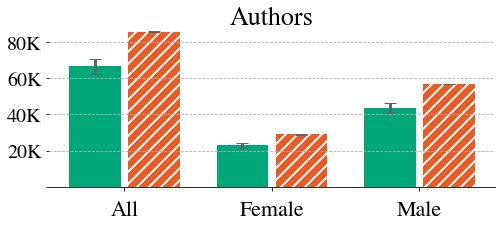

In [9]:
f = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=False)
m = get_inc(df,freq,split_date,gt_max_date,'m', num_papers=False)
tot = get_inc(df,freq,split_date,gt_max_date,'all', num_papers=False)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
        'Female':{'expected':f[0], 'real':f[1], 'expected_err':f[2], 'real_err':f[3], 'p':f[4], 'r2':f[5], 'coef':f[6]},
        'Male':{'expected':m[0], 'real':m[1], 'expected_err':m[2], 'real_err':m[3], 'p':m[4], 'r2':m[5], 'coef':m[6]}
       }

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = ['All', 'Female', 'Male']
ax.set_xticklabels(labels, fontsize=22)
ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.text(1,90000,'Authors',horizontalalignment='center', fontsize=26)
#plt.savefig("D:\\Downloads\\number_total.pdf", bbox_inches = 'tight', pad_inches = 0)

In [10]:
print('% increase in number of authors')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of authors
All: 28.796177685080565%
Female: 26.62288424249775%
Male: 29.93062138262508%


### Increase of number of papers

Text(1.5, 14000, 'Papers')

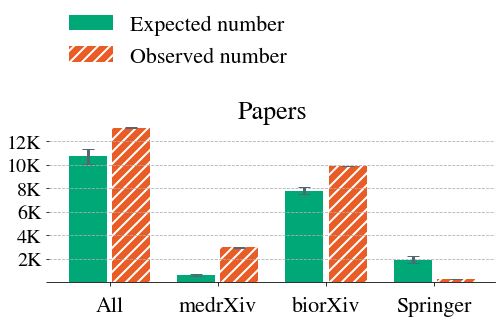

In [11]:
tot = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=True)
med = get_inc(df[df['platform']=='medrXiv'],freq,split_date,gt_max_date,'f', num_papers=True)
bio = get_inc(df[df['platform']=='biorXiv'],freq,split_date,gt_max_date,'m', num_papers=True)
sp = get_inc(df[df['platform']=='Springer'],freq,split_date,gt_max_date,'all', num_papers=True)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
    'medrXiv': {'expected':med[0], 'real':med[1], 'expected_err':med[2], 'real_err':med[3], 'p':med[4], 'r2':med[5], 'coef':med[6]},
        'biorXiv':{'expected':bio[0], 'real':bio[1], 'expected_err':bio[2], 'real_err':bio[3], 'p':bio[4], 'r2':bio[5], 'coef':bio[6]},
        'Springer':{'expected':sp[0], 'real':sp[1], 'expected_err':sp[2], 'real_err':sp[3], 'p':sp[4], 'r2':sp[5], 'coef':sp[6]}
       }

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected number')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed number')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = v.keys()

ax.set_xticklabels(labels, fontsize=22)

ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_ylabel('Papers', fontsize=24, labelpad=5)
ax.legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
ax.text(1.5,14000,'Papers',horizontalalignment='center', fontsize=26)
#plt.savefig("D:\\Downloads\\number_publishers.pdf", bbox_inches = 'tight', pad_inches = 0)

In [12]:
print('% increase in number of papers')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of papers
All: 22.59129418836916%
medrXiv: 363.8779707948013%
biorXiv: 26.8796464597577%
Springer: -84.595564024728%


### Gender differences in general across platforms

In [17]:
types = ['First','Any']
all_ = {}
for t in types:
    if t=='First':
        d = df1
    if t=='Any':
        d = df
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    all_[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}

medrxiv = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='medrXiv']
    if t=='Any':
        d = df[df['platform']=='medrXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    medrxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
biorxiv = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='biorXiv']
    if t=='Any':
        d = df[df['platform']=='biorXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    biorxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
springer = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='Springer']
    if t=='Any':
        d = df[df['platform']=='Springer']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    springer[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
    everything = {'biorXiv':biorxiv, 'medrXiv':medrxiv, 'Springer-Nature':springer}

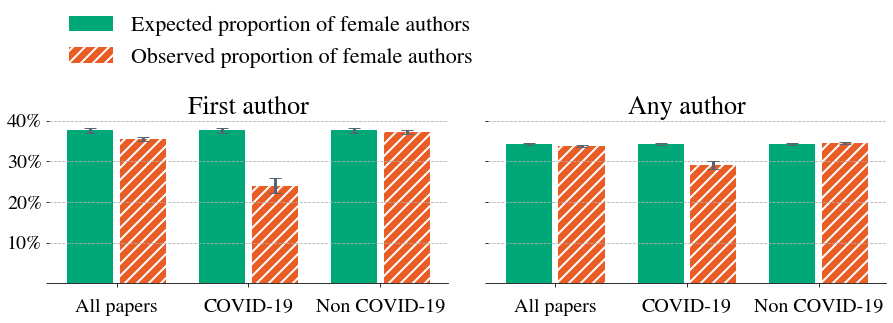

In [22]:
plot_data = {'All publishers':all_}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3), sharey=True)

j = 0
for c, v in all_.items():

    x = np.array(range(0,len(v.keys())))

    expected = [v['expected']*100 for k,v in v.items()]
    ax[j].bar(x-0.2,expected, width=0.35, 
              align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

    real = [v['real']*100 for k,v in v.items()]
    ax[j].bar(x+0.2,real, width=0.35, 
              align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')

    expected_err = [v['expected_err']*100 for k,v in v.items()]
    ax[j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
    real_err = [v['real_err']*100 for k,v in v.items()]
    ax[j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

    ax[j].set_xticks(x)
    ax[j].tick_params(axis='x', which='major', pad=12)
    labels = ['All papers', 'COVID-19', 'Non COVID-19']

    ax[j].set_xticklabels(labels, fontsize=20)
    ax[j].set_title(c+' author', fontsize=26)

    ax[j].yaxis.grid(True, which='major', linestyle='--')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    if j == 0:

        ax[j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
        ax[j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[j].get_yticks()][1:], size = 20)

    j+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)
#plt.savefig("D:\\Downloads\\gender_general_all.pdf", bbox_inches = 'tight', pad_inches = 0)

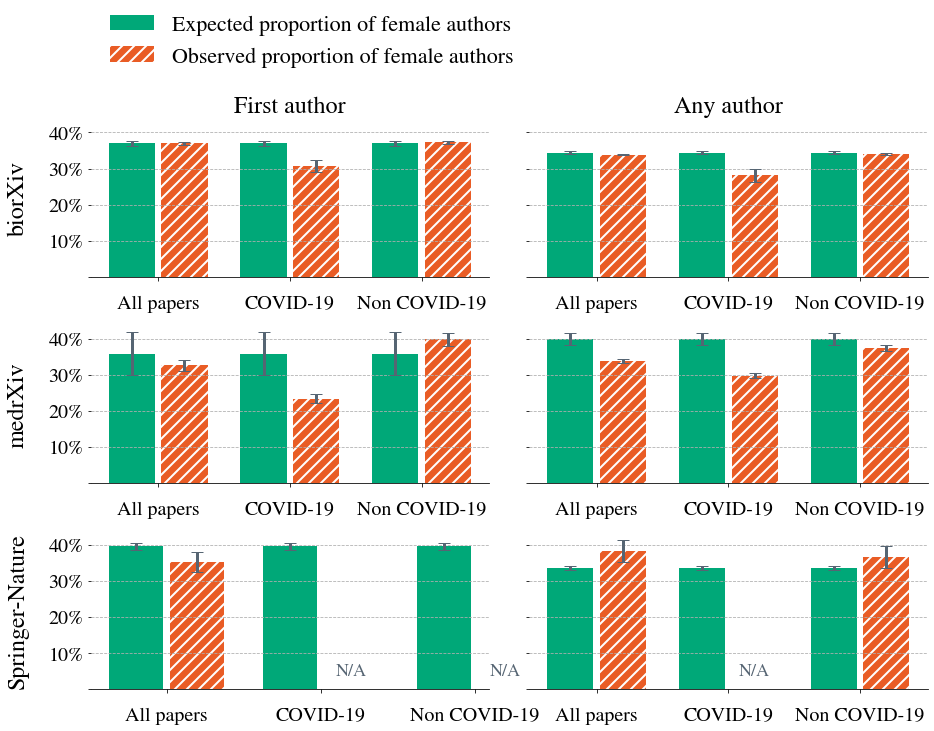

In [23]:
plot_data = everything

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3.5), sharey=True)

i = 0
for k, value in everything.items():
    j = 0
    for c, v in value.items():

        x = np.array(range(0,len(v.keys())))

        expected = [v['expected']*100 for k,v in v.items()]
        ax[i,j].bar(x-0.2,expected, width=0.35, 
                  align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

        real = [v['real']*100 for k,v in v.items()]
        ax[i,j].bar(x+0.2,real, width=0.35, 
                  align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')
        for loc,value in zip(x,real):
            if math.isnan(value):
                ax[i,j].text(loc+0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])

        expected_err = [v['expected_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
        real_err = [v['real_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

        
        ax[i,j].set_xticks(x)
        ax[i,j].tick_params(axis='x', which='major', pad=14)
        labels = ['All papers', 'COVID-19', 'Non COVID-19']
        
        ax[i,j].set_xticklabels(labels, fontsize=20)
        if i==0:
            ax[i,j].set_title(c+' author', fontsize=24)
        
        ax[i,j].yaxis.grid(True, which='major', linestyle='--')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        if j == 0:
            ax[i,j].set_ylabel(k, fontsize=24, labelpad=20)
            ax[i,j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[i,j].get_yticks()][1:], size = 20)
            if i == 0:
                ax[i,j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
            
        j+=1
    i+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)
#plt.margins(0,0)
#plt.tight_layout()
#plt.savefig("D:\\Downloads\\gender_general_publishers.pdf", bbox_inches = 'tight', pad_inches = 0)

In [24]:
df[df['platform']=='Springer']['hindex'].min()

12.0

### Gender differences across countries

In [29]:
countries_data = pd.read_csv('..\\data\\affiliations\\countries.csv')
countries_data['Name'] = countries_data['Name'].astype('str')
countries_data['Name'] = countries_data['Name'].str.title()
countries_data['Name'] = countries_data['Name'].str.replace(', Republic Of', '')
countries_data = countries_data.set_index('Code')
cc_map = countries_data['Name'].to_dict()

In [30]:
n=5000
cc = df[df['country_code']!=np.nan]
big = cc.groupby('country_code')['name'].count()[cc.groupby('country_code')['name'].count()>n].index.values
cc = cc[cc['country_code'].isin(big)]

#cc['country_code'] = cc['country_code'].replace(cc_map)

countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,freq,split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

    cd = gender_diff_frac(group,freq,split_date,gt_max_date, covid=True)
    countries_covid[name]= {'value':((cd[1]-cd[0])/cd[0])*100,'err':((cd[2]+cd[3])/cd[0])*100, 'raw':cd}
    
    cn = gender_diff_frac(group,freq,split_date,gt_max_date, covid=False)
    countries_noncovid[name]= {'value':((cn[1]-cn[0])/cn[0])*100,'err':((cn[2]+cn[3])/cn[0])*100, 'raw':cn}
    
data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}
geo_data = data

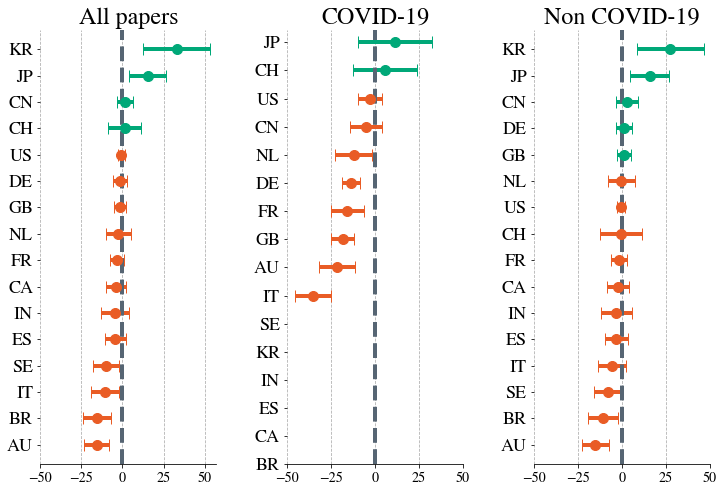

In [31]:
fig, ax = plt.subplots(1,3, figsize=(12, 8))
i=0
for name, d in data.items():
    countries_sort = OrderedDict(sorted(d.items(), key=lambda x: float('-inf') if math.isnan(x[1]['value']) else x[1]['value'], reverse=False))
    x = [v['value'] for v in countries_sort.values()]
    xerr = [v['err'] for v in countries_sort.values()]
    cols = [colors['myorange'] if v < 0 else colors['mygreen'] for v in x]
    
    y = range(0,len(countries_sort))
    for val, y_loc, err, col in zip(x,y,xerr,cols):
        ax[i].errorbar(val, y_loc, xerr=err, fmt='o', markersize=10, capsize=6, linewidth=4, color=col)
        
    ax[i].set_yticks(range(0,len(countries_sort)))
    labels = countries_sort.keys()
    ax[i].set_yticklabels(labels, fontsize=18)
    ax[i].xaxis.grid(True, which='major', linestyle='--')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    #ax[i].set_xlim(left=-70, right=70)
    ax[i].set_title(name, fontsize=24)
    ax[i].set_xticks([-50,-25,0,25,50], minor=False)
    ax[i].tick_params(axis='x', which='major', labelsize=14)
    ax[i].axvline(x=0, linewidth=4, linestyle='--', color=colors['darkgrey'])
    i+=1
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#plt.margins(0,0)
#plt.savefig("D:\\Downloads\\gender_geo.pdf", bbox_inches = 'tight', pad_inches = 0)

### GDP

In [32]:
covid_data = pd.read_csv('..\\data\\owid-covid-data.csv')#, usecols=['location','total_cases_per_million', 'date'])
covid_data = covid_data[covid_data['date']==gt_max_date].drop(columns=['date'])
covid_data['location'] = covid_data['location'].astype('str').str.lower()

In [33]:
countries_data = pd.read_csv('..\\data\\affiliations\\countries.csv')
countries_data['Name'] = countries_data['Name'].astype('str')
countries_data['Name'] = countries_data['Name'].replace('korea, republic of', 'south korea')
countries_data = countries_data.set_index('Name')
covid_data = covid_data.join(countries_data, on='location')
covid_data['location'] = covid_data['location'].str.title()

In [34]:
asia = ['Japan', 'South Korea', 'China', 'India']

In [35]:
cc = df[df['country_code']!=np.nan]
#big = cc.groupby('country_code')['name'].count()[cc.groupby('country_code')['name'].count()>n].index.values
cc = cc[(cc['country_code'].isin(big))&(cc['date']<=split_date)]
g = cc.groupby('country_code')

d = g.apply(f_fraction).to_frame().rename(columns={0:'frac_before'})
d2 = pd.DataFrame.from_dict(data['All papers'],orient='index').rename(columns={'value':'drop'})[['drop']]
cd = covid_data[covid_data['Code'].isin(d.index)]
cd = cd.join(d, on='Code').join(d2, on='Code')
cd['region'] = ['Asia' if x in asia else 'Europe and Americas' for x in cd['location']]
cd = cd[['location','gdp_per_capita','frac_before','drop','region']]
# replace South Korea with S. Korea
cd['location'] = cd['location'].str.replace('South Korea', 'S.Korea')

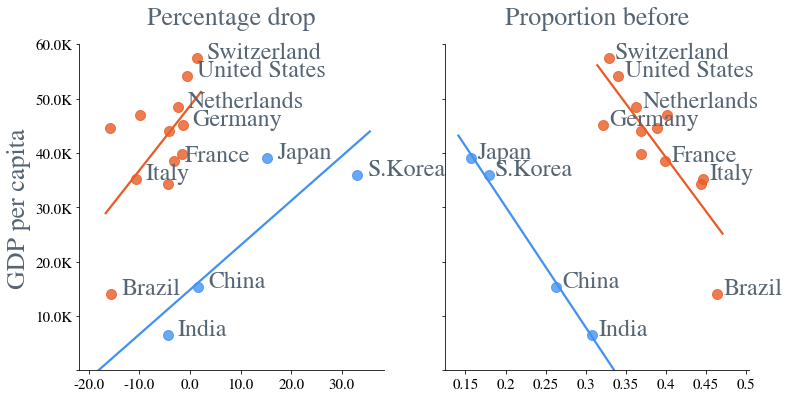

In [37]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
regions = ['Europe and Americas', 'Asia']
cols = [colors['myorange'], colors['myblue']]
for i in range(0,2):
    sns.regplot(x="drop", y="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[0], ci=0, color=cols[i], label=regions[i], scatter_kws={"s": 100})
    sns.regplot(x="frac_before", y="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[1], ci=0, color = cols[i], label = regions[i],scatter_kws={"s": 100})

forbid_names = ['Canada','United Kingdom','Sweden','Australia','Spain']
for i in range(0,2):

    ax[i].set_xlabel('')
    ax[i].set_ylim(0,60000)
    ax[i].set_yticklabels([''] + [str(round(x/1000,0))+'K' for x in ax[i].get_yticks()][1:], size = 15)
    ax[i].legend(ncol=1, fontsize=22, frameon=False, loc='upper left', bbox_to_anchor=(0.01, 1))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    if i == 0:
        ax[i].set_ylabel("GDP per capita", fontsize=26, color=colors['darkgrey'])
        ax[i].set_title("Percentage drop", fontsize=26, color=colors['darkgrey'], pad=20)
        ax[i].set_xticklabels([str(round(x,2)) for x in ax[i].get_xticks()], size = 15)
        for j, txt in enumerate(cd['location']):
            if txt not in forbid_names:
                ax[i].annotate(txt, (cd['drop'].iloc[j]+2, cd['gdp_per_capita'].iloc[j]),
                                 fontsize=24, horizontalalignment='left', color=colors['darkgrey'])
    if i == 1:
        ax[i].set_ylabel('')
        ax[i].set_title("Proportion before", fontsize=26, color=colors['darkgrey'], pad=20)
        ax[i].set_xticklabels([str(round(x,2)) for x in ax[i].get_xticks()], size = 15)
        for j, txt in enumerate(cd['location']):
            if txt not in forbid_names:
                ax[i].annotate(txt, (cd['frac_before'].iloc[j]+0.008, cd['gdp_per_capita'].iloc[j]),
                                 fontsize=24, horizontalalignment='left', color=colors['darkgrey'])
    ax[i].get_legend().remove()

#plt.savefig("D:\\Downloads\\gdp_before_after.pdf", bbox_inches = 'tight', pad_inches = 0)

### World

In [ ]:
n=5000
cc = df[df['country_code']!=np.nan]
#big = cc.groupby('country_code')['name'].count()[cc.groupby('country_code')['name'].count()>n].index.values
#cc = cc[cc['country_code'].isin(big)]

#cc['country_code'] = cc['country_code'].replace(cc_map)

countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,'W',split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

#data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}

In [ ]:
cd

In [ ]:
d2 = pd.DataFrame.from_dict(countries_all,orient='index').rename(columns={'value':'drop'})[['drop']]
cd = covid_data.join(d2, on='Code')
cd = cd[~cd['drop'].isna()]

In [ ]:
import plotly.graph_objects as go

data=go.Choropleth(
    locations = cd['iso_code'],
    z = cd['drop'],
    zmid=0,
    
    #text = df['COUNTRY'],
    colorscale = px.colors.diverging.RdBu,
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_ticksuffix = '%',
    #colorbar_title = '',
    colorbar=dict(thickness=30,
                  len=0.65,
                           ticklen=0, tickcolor='black',
                           tickfont=dict(size=22, color='grey'))
)

layout = dict(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    geo = dict(
        landcolor = 'lightgray',
        showland = True,
        showcountries = False,
        countrycolor = 'gray',
        countrywidth = 0.5,
        showframe=False,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data, layout = layout)

# fig.update_layout(
#     margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
# )

fig.show()
fig.write_image("D:\\Downloads\\world.pdf")
#plt.savefig("D:\\Downloads\\world.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = px.choropleth(cd, locations="iso_code",
                    color="drop", # lifeExp is a column of gapminder
                    color_continuous_scale=px.colors.diverging.RdBu)
fig.show()
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Tables

In [38]:
all_f = pd.DataFrame.from_dict(all_['First']).T.reset_index()
all_f['order'] = 'First'
all_a = pd.DataFrame.from_dict(all_['Any']).T.reset_index()
all_a['order'] = 'Any'

a = pd.concat([all_f,all_a]).rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
a['publisher'] = 'All publishers'

med_f = pd.DataFrame.from_dict(medrxiv['First']).T.reset_index()
med_f['order'] = 'First'
med_a = pd.DataFrame.from_dict(medrxiv['Any']).T.reset_index()
med_a['order'] = 'Any'

m = pd.concat([med_f,med_a]).rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
m['publisher'] = 'medrXiv'

bio_f = pd.DataFrame.from_dict(biorxiv['First']).T.reset_index()
bio_f['order'] = 'First'
bio_a = pd.DataFrame.from_dict(biorxiv['Any']).T.reset_index()
bio_a['order'] = 'Any'

b = pd.concat([bio_f,bio_a]).rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
b['publisher'] = 'biorXiv'

spr_f = pd.DataFrame.from_dict(springer['First']).T.reset_index()
spr_f['order'] = 'First'
spr_a = pd.DataFrame.from_dict(springer['Any']).T.reset_index()
spr_a['order'] = 'Any'

s = pd.concat([spr_f,spr_a]).rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
s['publisher'] = 'Springer-Nature'

In [39]:
res = pd.concat([a,b,m,s])
res['papers'] = res['papers'].replace({'COVID':'COVID-19', 'nonCOVID':'Non COVID-19'})
res = res.set_index(['publisher','order','papers'])
res['% diff'] = ((res['ar. mean']-res['observed ar. mean'])/res['ar. mean'])*100
res = res.round(3)
res = res.drop(columns=['coef','p value','r2'])

In [40]:
res

ar. mean  st. err  observed ar. mean  \
publisher       order papers                                               
All publishers  First All              0.376    0.007              0.354   
                      COVID-19         0.376    0.007              0.240   
                      Non COVID-19     0.376    0.007              0.373   
                Any   All              0.342    0.003              0.337   
                      COVID-19         0.342    0.003              0.292   
                      Non COVID-19     0.342    0.003              0.344   
biorXiv         First All              0.370    0.007              0.369   
                      COVID-19         0.370    0.007              0.307   
                      Non COVID-19     0.370    0.007              0.372   
                Any   All              0.344    0.003              0.339   
                      COVID-19         0.344    0.003              0.281   
                      Non COVID-19     0.344    0.003              0.341   
medrXiv         First All              0.358    0.060              0.326   
                      COVID-19         0.358    0.060              0.233   
                      Non COVID-19     0.358    0.060              0.398   
                Any   All              0.399    0.017              0.339   
                      COVID-19         0.399    0.017              0.297   
                      Non COVID-19     0.399    0.017              0.375   
Springer-Nature First All              0.396    0.010              0.352   
                      COVID-19         0.396    0.010                NaN   
                      Non COVID-19     0.396    0.010                NaN   
                Any   All              0.334    0.005              0.383   
                      COVID-19         0.334    0.005                NaN   
                      Non COVID-19     0.334    0.005              0.366   

                                    observed st. err  % diff  
publisher       order papers                                  
All publishers  First All                      0.005   5.782  
                      COVID-19                 0.018  36.149  
                      Non COVID-19             0.004   0.831  
                Any   All                      0.002   1.585  
                      COVID-19                 0.010  14.753  
                      Non COVID-19             0.002  -0.475  
biorXiv         First All                      0.004   0.125  
                      COVID-19                 0.016  16.892  
                      Non COVID-19             0.004  -0.685  
                Any   All                      0.002   1.696  
                      COVID-19                 0.019  18.367  
                      Non COVID-19             0.002   1.127  
medrXiv         First All                      0.016   9.090  
                      COVID-19                 0.013  34.910  
                      Non COVID-19             0.019 -11.076  
                Any   All                      0.005  15.009  
                      COVID-19                 0.007  25.587  
                      Non COVID-19             0.008   6.079  
Springer-Nature First All                      0.027  11.167  
                      COVID-19                   NaN     NaN  
                      Non COVID-19               NaN     NaN  
                Any   All                      0.030 -14.495  
                      COVID-19                   NaN     NaN  
                      Non COVID-19             0.031  -9.462

In [ ]:
print(res.to_latex(index=True))

In [41]:
# fraction of covid papers:
platforms = ['biorXiv', 'medrXiv', 'Springer']
for platform in platforms:
    print(platform)
    print(len(df[(df['platform']==platform) & (df['is_covid']==1)])/len(df[df['platform']==platform])*100)

biorXiv
2.367555098626634
medrXiv
48.94156063506362
Springer
0.32870552885896026


In [47]:
#n=5000
cc = df[df['country_code']!=np.nan]
#cc = cc[cc['platform'].isin(['Springer'])]
#big = cc.groupby('country_code')['name'].count()[cc.groupby('country_code')['name'].count()>n].index.values
#cc = cc[cc['country_code'].isin(big)]

#cc['country_code'] = cc['country_code'].replace(cc_map)

countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,freq,split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

    cd = gender_diff_frac(group,freq,split_date,gt_max_date, covid=True)
    countries_covid[name]= {'value':((cd[1]-cd[0])/cd[0])*100,'err':((cd[2]+cd[3])/cd[0])*100, 'raw':cd}
    
    cn = gender_diff_frac(group,freq,split_date,gt_max_date, covid=False)
    countries_noncovid[name]= {'value':((cn[1]-cn[0])/cn[0])*100,'err':((cn[2]+cn[3])/cn[0])*100, 'raw':cn}
    
data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}
geo_data = data

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [49]:
f = {}
for name, v in geo_data['All papers'].items():
    f[name] = {'model ar. mean.':v['raw'][0], 'model st. err':v['raw'][2],
               'obs ar. mean':v['raw'][1], 'obs st. err':v['raw'][3], '% diff':v['value']}
f_all = pd.DataFrame.from_dict(f).T
f_all = f_all[list(f_all.columns[1:]) + [f_all.columns[0]]]

f = {}
for name, v in geo_data['COVID-19'].items():
    f[name] = {'model ar. mean.':v['raw'][0], 'model st. err':v['raw'][2],
               'obs ar. mean':v['raw'][1], 'obs st. err':v['raw'][3], '% diff':v['value']}
f_covid = pd.DataFrame.from_dict(f).T
f_covid = f_covid[list(f_covid.columns[1:]) + [f_covid.columns[0]]]

f = {}
for name, v in geo_data['Non COVID-19'].items():
    f[name] = {'model ar. mean.':v['raw'][0], 'model st. err':v['raw'][2],
               'obs ar. mean':v['raw'][1], 'obs st. err':v['raw'][3], '% diff':v['value']}
f_noncovid = pd.DataFrame.from_dict(f).T
f_noncovid = f_noncovid[list(f_noncovid.columns[1:]) + [f_noncovid.columns[0]]]

In [50]:
#f_all[''] = ''
res = pd.concat([f_all,f_covid], axis='columns').reset_index()
map_c = {'AU':'Australia', 'BR':'Brazil', 'CA':'Canada', 'CH':'Switzerland', 'CN':'China',
                                   'DE':'Germany','ES':'Spain','FR':'France','GB':'United Kingdom','IN':'India',
                                   'IT':'Italy','JP':'Japan','KR':'South Korea','NL':'Netherlands', 'SE':'Sweden', 
                                   'US':'United States'}
res['index'] = res['index'].replace(map_c)
res = res.sort_values(by='index').set_index('index')
res = res.round(3).fillna('--')

In [51]:
res.insert(2, '- ', '')
res.insert(6, '--', '')
res.insert(9, '---', '')

In [52]:
res

,model ar. mean.,model st. err,-,obs ar. mean,obs st. err,% diff,--,model ar. mean.,model st. err,---,obs ar. mean,obs st. err,% diff
index,,,,,,,,,,,,,
AE,--,--,,0.492,0.002,--,,--,--,,--,--,--
AF,--,--,,--,--,--,,--,--,,--,--,--
AG,--,--,,--,--,--,,--,--,,--,--,--
AL,--,--,,--,--,--,,--,--,,--,--,--
AM,--,--,,--,--,--,,--,--,,--,--,--
AR,0.481,0.045,,0.455,0.032,-5.309,,0.481,0.045,,--,--,--
AT,0.328,0.021,,0.343,0.012,4.818,,0.328,0.021,,--,--,--
AZ,--,--,,--,--,--,,--,--,,--,--,--
Australia,0.386,0.015,,0.325,0.014,-15.753,,0.386,0.015,,0.302,0.025,-21.722


In [ ]:
print(res.to_latex(index=True))

In [ ]:
cnt['US']/sum(cnt)

In [ ]:
df

In [ ]:
counties

In [ ]:
df